# Big Data Real-Time Analytics with Python and Spark

## Chapter 14 - Apache Spark Machine Learning

### Mini project 5 - Civil Engineering with Apache Spark

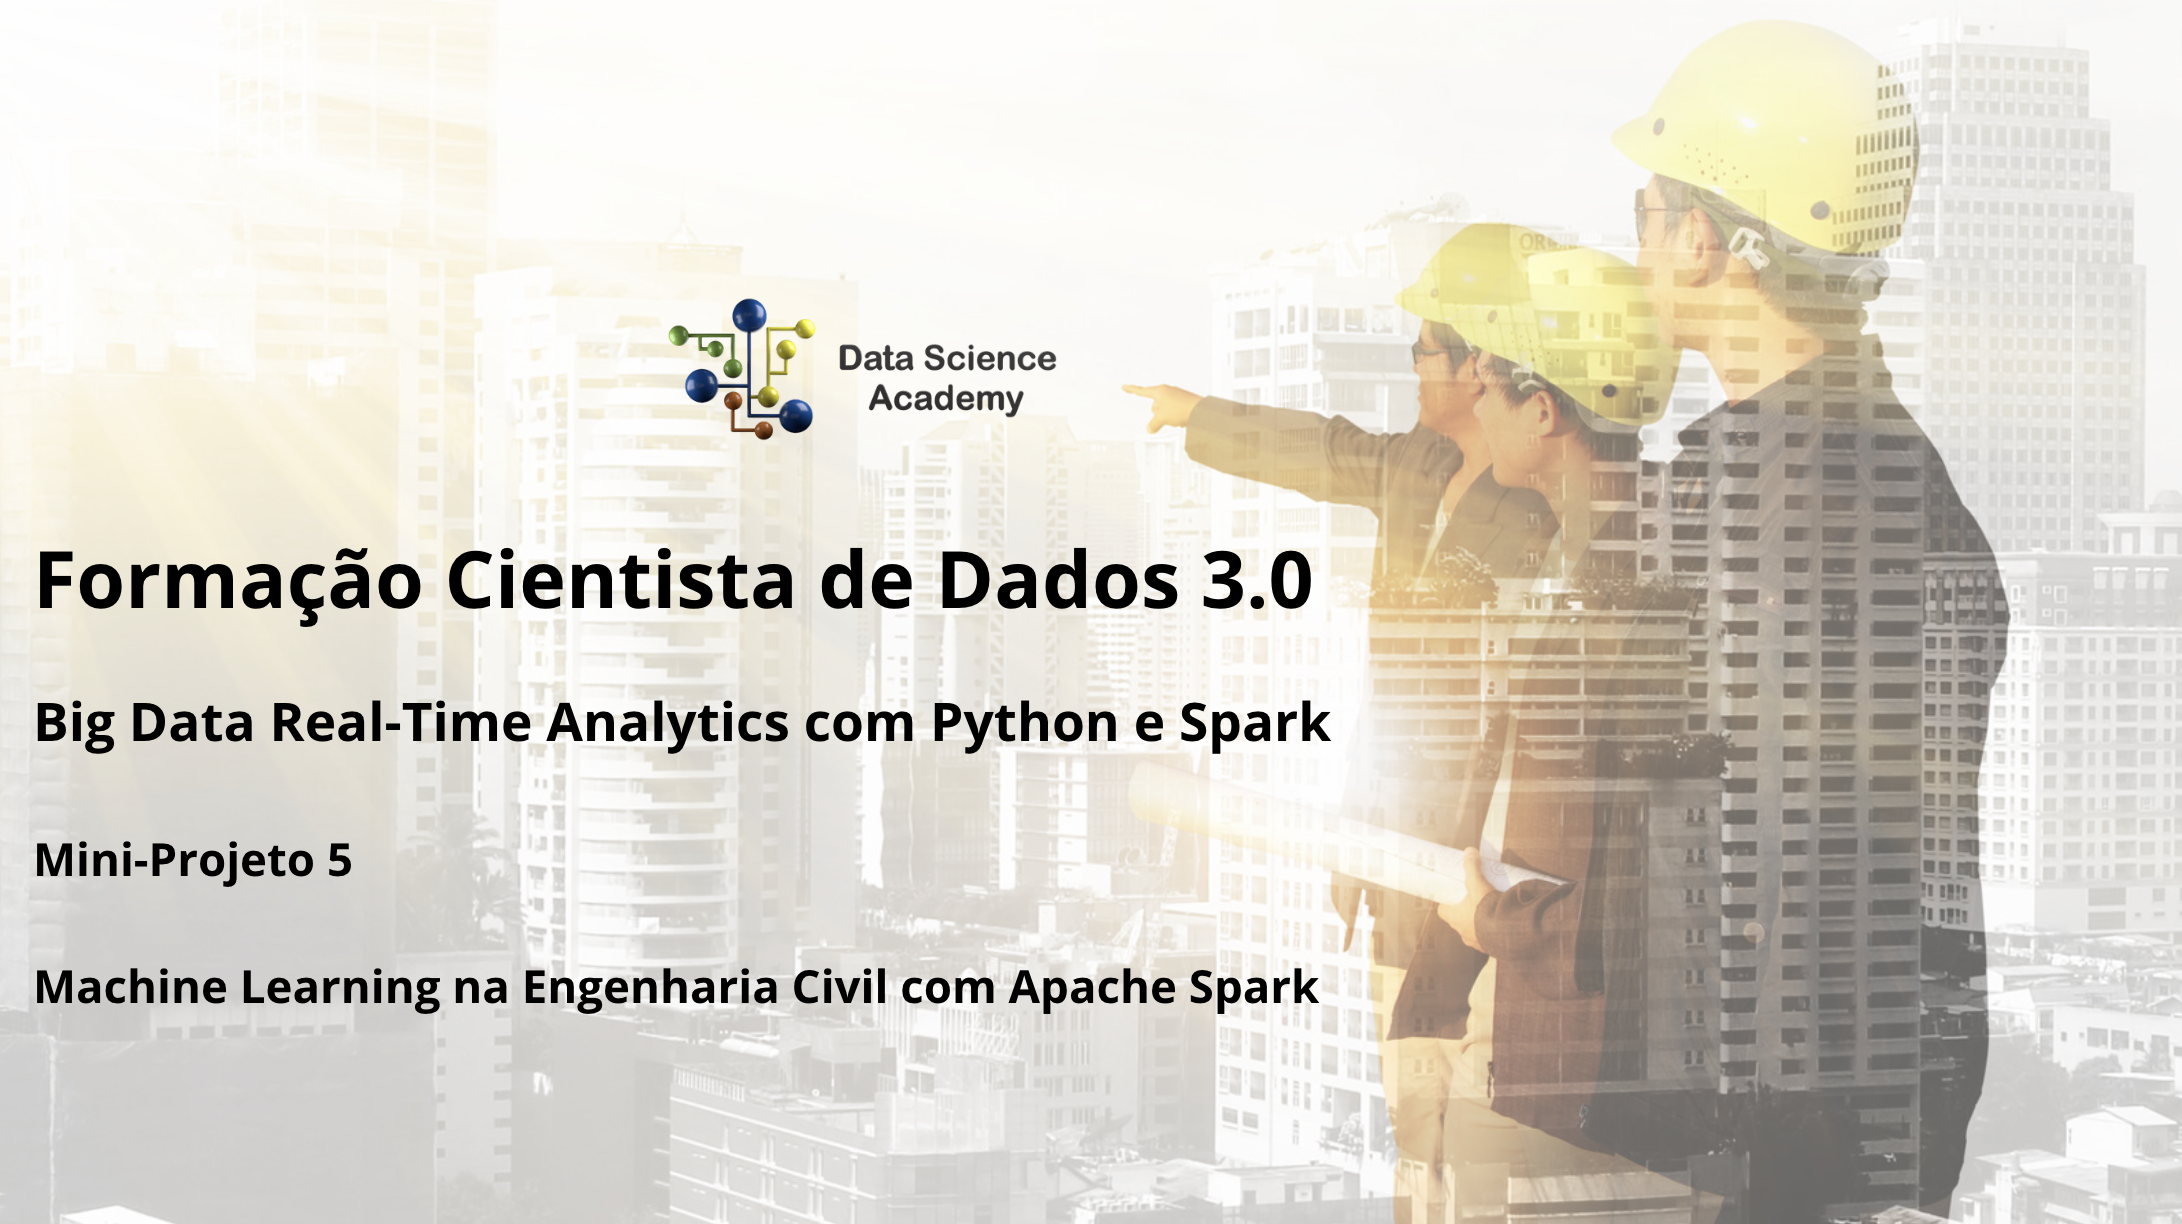

In [1]:
# Python version
from platform import python_version
print('The version of python used in this notebook is: ', python_version())

The version of python used in this notebook is:  3.8.13


In [2]:
# Import findspark and inicialize it
import findspark
findspark.init()

In [3]:
# Imports
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
# Package versions used in this notebook
%reload_ext watermark
%watermark -a 'Bianca Amorim' --iversions

Author: Bianca Amorim

pyspark  : 3.3.1
sys      : 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0]
findspark: 2.0.1



## Preparing Spark's Environment

In [5]:
# Create Spark Context
sc = SparkContext(appName = 'Mini-Project5')

22/12/20 13:28:47 WARN Utils: Your hostname, Avell resolves to a loopback address: 127.0.1.1; using 192.168.1.81 instead (on interface wlo1)
22/12/20 13:28:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/20 13:28:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/20 13:28:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/12/20 13:28:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/12/20 13:28:50 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/12/20 13:28:50 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/12/20 13:28:50 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.


In [6]:
sc.setLogLevel('ERROR')

In [7]:
# Create Session
spark = SparkSession.builder.getOrCreate()

In [8]:
spark

## Loading Data

In [9]:
# Loading Data
dataset = spark.read.csv('datasets/dataset.csv', inferSchema = True, header = True)

In [10]:
type(dataset)

pyspark.sql.dataframe.DataFrame

In [11]:
# Number of records
dataset.count()

1030

In [12]:
# Visualizes the data in the Spark DataFrame pattern
dataset.show(10)

+------+-----+------+-----+----------------+---------------+-------------+---+-----+
|cement| slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|csMPa|
+------+-----+------+-----+----------------+---------------+-------------+---+-----+
| 540.0|  0.0|   0.0|162.0|             2.5|         1040.0|        676.0| 28|79.99|
| 540.0|  0.0|   0.0|162.0|             2.5|         1055.0|        676.0| 28|61.89|
| 332.5|142.5|   0.0|228.0|             0.0|          932.0|        594.0|270|40.27|
| 332.5|142.5|   0.0|228.0|             0.0|          932.0|        594.0|365|41.05|
| 198.6|132.4|   0.0|192.0|             0.0|          978.4|        825.5|360| 44.3|
| 266.0|114.0|   0.0|228.0|             0.0|          932.0|        670.0| 90|47.03|
| 380.0| 95.0|   0.0|228.0|             0.0|          932.0|        594.0|365| 43.7|
| 380.0| 95.0|   0.0|228.0|             0.0|          932.0|        594.0| 28|36.45|
| 266.0|114.0|   0.0|228.0|             0.0|          932.0|     

In [13]:
# Visualizes the data in Pandas format
dataset.limit(10).toPandas()

cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0   540.0    0.0     0.0  162.0               2.5           1040.0   
1   540.0    0.0     0.0  162.0               2.5           1055.0   
2   332.5  142.5     0.0  228.0               0.0            932.0   
3   332.5  142.5     0.0  228.0               0.0            932.0   
4   198.6  132.4     0.0  192.0               0.0            978.4   
5   266.0  114.0     0.0  228.0               0.0            932.0   
6   380.0   95.0     0.0  228.0               0.0            932.0   
7   380.0   95.0     0.0  228.0               0.0            932.0   
8   266.0  114.0     0.0  228.0               0.0            932.0   
9   475.0    0.0     0.0  228.0               0.0            932.0   

   fineaggregate  age  csMPa  
0          676.0   28  79.99  
1          676.0   28  61.89  
2          594.0  270  40.27  
3          594.0  365  41.05  
4          825.5  360  44.30  
5          670.0   90  47.03  
6          594.0  365  43.70  
7          594.0   28  36.45  
8          670.0   28  45.85  
9          594.0   28  39.29

In [14]:
# Schema
dataset.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



## Data Preparation Automation Module

MLib requires that all input columns of the dataframe be vectorized. We will create a Python function that will automate our data preparation work, including vectorization and all the necessary tasks.

In [15]:
# First, we will separate and remove missing values (if there are)
dataset_with_rows_removed = dataset.na.drop()
print('Number of rows before removing missing values:', dataset.count())
print('Number of rows after removing missing values:', dataset_with_rows_removed.count())

Number of rows before removing missing values: 1030
Number of rows after removing missing values: 1030


In [16]:
# Data preparation function
def data_prep_module_function(df,
                             input_variables,
                             output_variable,
                             treat_outliers = True,
                             standardize_data = True):
    
    # Let's generate a new dataframe, renaming the argument that represents the output variable
    new_df = df.withColumnRenamed(output_variable, 'label')
    
    
    # ENCODING
    
    # Converting the target variable to the numerical type as a float (encoding)
    if str(new_df.schema['label'].dataType) != 'IntegerType':
        new_df = new_df.withColumn('label', new_df['label'].cast(FloatType()))
        
    # Control list for the variables
    numerical_variables = []
    categorical_variables = []
    
    # If there is any variable of string type, we convert to a numerical type
    for column in input_variables:
        
        # Check if the variable is a string
        if str(new_df.schema[column].dataType) == 'StringType':
            
            # Define variable with a suffix
            new_column_name = column + '_num'
            
            # Add to the categorical list
            categorical_variables.append(new_column_name)
        
        else:
            
            # If it is not a string variable, then it is numerical and we add it to the corresponding list
            numerical_variables.append(column)
            
            # We put the data into the indexed variable dataframe
            df_indexed = new_df
            
    # If the dataframe contains string data, we apply indexing 
    # Check if the list of categorical variables is not empty
    if len(categorical_variables) != 0:
        
        # Loop for the columns
        for column in new_df:
            
            # If the variable is of type string, we create, train, and apply the indexer
            if str(new_df.schema['column'].dataType) == 'StringType':
                
                # Create indexer
                indexer = StringIndexer(inputCol = column, outputCol = column + '_num')
                
                # Train and apply indexer
                df_indexed = indexer.fit(new_df).transform(new_df)
                
    else:
        
        # If we no longer have categorical variables, then we put the data into the indexed variables dataframe
        df_indexed = new_df
        
    
    # TREAT OUTLIERS 
    
    # If it is necessary to treat outliers, we will do that now
    if treat_outliers == True:
        print('\nApplying outlier treatment...')
        
        # Dictionary
        d = {}
            
        # Quartile dictionary of indexed dataframe variables (numerical variables only)
        for col in numerical_variables:
            d[col] = df_indexed.approxQuantile(col, [0.01, 0.99], 0.25)
        
        # Now we apply transformation depending on the distribution of each variable
        for col in numerical_variables:
            
            # We stratify the asymmetry of the data and use this to deal with outliers
            skew = df_indexed.agg(skewness(df_indexed[col])).collect()
            skew = skew[0][0]
            
            # We check the asymmetry and then apply:
            
            # Log transformation + 1 if the asymmetry is positive
            if skew > 1:
                indexed = df_indexed.withColumn(col, log(when(df[col] < d[col][0], d[col][0])\
                .when(df_indexed[col] > d[col][1], d[col][1])\
                .otherwise(df_indexed[col] ) + 1).alias(col))
                print('\nThe variable ' + col + ' was treated for positive (right) asymmetry with skew =', skew)
                
            # Exponential transformation if the asymmetry is negative
            elif skew < -1:
                indexed = df_indexed.withColumn(col, \
                exp(when(df[col] < d[col][0], d[col][0])\
                .when(df_indexed[col] > d[col][1], d[col][1])\
                .otherwise(df_indexed[col] )).alias(col))
                print('\nThe variable ' + col + ' was treated for negative (left) skewness with skew =', skew)
                
            # Asymmetry between -1 e 1 we do not need to apply transformation to the data
            
    
    # VECTORIZATION
    
    # List of features
    features_list = numerical_variables + categorical_variables
    
    # Creates the vectorizer for the attributes
    vectorizer = VectorAssembler(inputCols = features_list, outputCol = 'features')
    
    # Apply vectorizer to the dataset
    vectorized_data = vectorizer.transform(df_indexed).select('features', 'label')
    
    
    # STANDARDIZATION
    
    # If the standardize_data flag is set to True, then we standardize the data by putting it on the same scale
    if standardize_data == True:
        print('\nStandardizing the data set to the range 0 to 1...')
        
        # Create scaler
        scaler = MinMaxScaler(inputCol = 'features', outputCol = 'scaledFeatures')
        
        # Calculates the summary statistics and generates the standardizer
        global scalerModel
        scalerModel = scaler.fit(vectorized_data)
        
        # Standardizes the variables to the interval [min, max]
        standardized_data = scalerModel.transform(vectorized_data)
        
        # Generate final data
        final_data = standardized_data.select('label', 'scaledFeatures')
        
        # Rename columns (Required by spark)
        final_data = final_data.withColumnRenamed('scaledFeatures', 'features')
        
        print('\nProcess completed!')
        
    # If the standardize_data flag is set to False, then we do not standardize the data
    else:
        print('\nThe data will not be standardized because the flag standardize_data is set to False')
        final_data = vectorized_data
        
    return final_data

> Now we apply the data preparation module

In [17]:
# List of input variables (all except the last one)
input_variables = dataset.columns[:-1]

In [18]:
# Target variable
output_variable = dataset.columns[-1]

In [19]:
# Apply the function
final_dataset = data_prep_module_function(dataset, input_variables, output_variable)


Applying outlier treatment...

The variable age was treated for positive (right) asymmetry with skew = 3.2644145354168086

Standardizing the data set to the range 0 to 1...

Process completed!


In [20]:
# Visualize
final_dataset.show(10, truncate = False)

+-----+------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                      |
+-----+------------------------------------------------------------------------------------------------------------------------------+
|79.99|[1.0,0.0,0.0,0.3210862619808307,0.07763975155279502,0.6947674418604651,0.20572002007024587,0.07417582417582418]               |
|61.89|[1.0,0.0,0.0,0.3210862619808307,0.07763975155279502,0.7383720930232558,0.20572002007024587,0.07417582417582418]               |
|40.27|[0.526255707762557,0.3964941569282137,0.0,0.8482428115015974,0.0,0.3808139534883721,0.0,0.739010989010989]                    |
|41.05|[0.526255707762557,0.3964941569282137,0.0,0.8482428115015974,0.0,0.3808139534883721,0.0,1.0]                                  |
|44.3 |[0.22054794520547943,0.3683917640511965,0.0,0.56

## Checking the Correlation

Let's make sure that we have no multicollinearity before we proceed. Remember the following directions for Pearson's Coefficient of Correlation:

- .00-.19 (Very weak correlation)
- .20-.39 (Weak correlation)
- .40-.59 (Moderate correlation)
- .60-.70 (Strong correlation)
- .80-1.0 (Very strong correlation)

In [21]:
# Extract correlation
coefficient_corr = Correlation.corr(final_dataset, 'features', 'pearson').collect()[0][0]

In [22]:
# Convert the result to an array
array_corr = coefficient_corr.toArray()

In [23]:
array_corr

array([[ 1.        , -0.27521591, -0.39746734, -0.08158675,  0.09238617,
        -0.10934899, -0.22271785,  0.08194602],
       [-0.27521591,  1.        , -0.3235799 ,  0.10725203,  0.04327042,
        -0.28399861, -0.28160267, -0.04424602],
       [-0.39746734, -0.3235799 ,  1.        , -0.25698402,  0.37750315,
        -0.00996083,  0.07910849, -0.15437052],
       [-0.08158675,  0.10725203, -0.25698402,  1.        , -0.65753291,
        -0.1822936 , -0.45066117,  0.27761822],
       [ 0.09238617,  0.04327042,  0.37750315, -0.65753291,  1.        ,
        -0.26599915,  0.22269123, -0.19270003],
       [-0.10934899, -0.28399861, -0.00996083, -0.1822936 , -0.26599915,
         1.        , -0.17848096, -0.00301588],
       [-0.22271785, -0.28160267,  0.07910849, -0.45066117,  0.22269123,
        -0.17848096,  1.        , -0.1560947 ],
       [ 0.08194602, -0.04424602, -0.15437052,  0.27761822, -0.19270003,
        -0.00301588, -0.1560947 ,  1.        ]])

In [24]:
# List the correlation between features and target variable
for item in array_corr:
    print(item[7])

0.08194602387182176
-0.044246019304454175
-0.15437051606792915
0.27761822152100296
-0.19270002804347258
-0.0030158803467436645
-0.15609470264758615
1.0


## Split train and test dataset

In [25]:
# Split with the proportion 70/30
train_data, test_data = final_dataset.randomSplit([0.7,0.3])

## Auto ML Module (Automated Machine Learning) 

https://spark.apache.org/docs/latest/ml-classification-regression.html#regression

Let's create a function to automate the use of several algorithms. Our function will be to create, train and evaluate each of them with different combinations of hyperparameters. Then we will choose the best-performing model.

In [48]:
# Machine Learning Module
def ml_module_func(regression_algorithm):
    
    # Function to get the type of the regression algorithm and create the instance of the object
    # We will use this to automate the process
    def func_type_algo(regression_algo):
        algorithm = regression_algo
        type_algo = type(algorithm).__name__
        return type_algo
    
    # Apply the previous function
    type_algo = func_type_algo(regression_algorithm)
    
    # If the algorithm is Linear Regression, we enter in this block if
    if type_algo == 'LinearRegression':
        
        # We train the first version of the model without cross-validation
        model = regressor.fit(train_data)
        
        # Model metrics
        print('\033[1m' + "Linear Regression Model without Cross-validation:" + '\033[0m')
        print("")
        
        # Evaluates the model with test data
        test_result = model.evaluate(test_data)
        
        # Prints model error metrics with test data
        print('RMSE in test: {}'.format(test_result.rootMeanSquaredError))
        print('Coefficient R2 in Test: {}'.format(test_result.r2))
        print('')
        
        
        # Now let's create the SECOND VERSION of the model with the same algorithm, but using cross-validation
        
        # Prepare hyperparameter grid
        paramGrid = (ParamGridBuilder().addGrid(regressor.regParam, [0.1, 0.01]).build())
        
        # Create Evaluators
        eval_rmse = RegressionEvaluator(metricName = 'rmse')
        eval_r2 = RegressionEvaluator(metricName = 'r2')
        
        # Create a Cross Validator
        crossval = CrossValidator(estimator = regressor, 
                                 estimatorParamMaps = paramGrid,
                                 evaluator = eval_rmse,
                                 numFolds = 3)
        
        print('\033[1m' + "Linear Regression Model with Cross-validation:" + '\033[0m')
        print("")
        
        # Train the model with cross-validation
        model = crossval.fit(train_data)
        
        # Save the best model of version 2
        global LR_BestModel
        LR_BestModel = model.bestModel
        
        # Predictions with test data
        predictions = LR_BestModel.transform(test_data)
        
        # Evaluation of the best model
        rmse_test_result = eval_rmse.evaluate(predictions)
        print('RMSE in test:', rmse_test_result)
        
        r2_test_result = eval_r2.evaluate(predictions)
        print('Coefficient R2 in test:', r2_test_result)
        print("")
        
        # List of columns to put in the summary dataframe
        columns = ['Regressor', 'Result_RMSE', 'Result_R2']
        
        # List of columns to put in the summary dataframe
        
        # Formats the metrics and name of the algorithm
        rmse_str = [str(rmse_test_result)]
        r2_str = [str(r2_test_result)]
        type_algo = [type_algo]
        
        # Create the dataframe
        df_result = spark.createDataFrame(zip(type_algo, rmse_str, r2_str), schema = columns)
        
        # Saves the results in the dataframe
        df_result = df_result.withColumn('Result_RMSE', df_result.Result_RMSE.substr(0, 5))
        df_result = df_result.withColumn('Result_R2', df_result.Result_R2.substr(0, 5))
        
        return df_result
    
    else:
        
        # We check if the algorithm is Decision Tree and create the hyperparameter grid
        if type_algo in('DecisionTreeRegressor'):
            paramGrid = (ParamGridBuilder().addGrid(regressor.maxBins, [10, 20, 40]).build())
            
        # We check if the algorithm is Random Forest and create the hyperparameter grid
        if type_algo in('RandomForestRegressor'):
            paramGrid = (ParamGridBuilder().addGrid(regressor.numTrees, [5, 20]).build())
            
        # We check if the algorithm is GBT and create the hyperparameter grid
        if type_algo in('GBTRegressor'):
            paramGrid = (ParamGridBuilder() \
                        .addGrid(regressor.maxBins, [10, 20]) \
                        .addGrid(regressor.maxIter, [10, 15])
                        .build())
            
        # We check if the algorithm is Isotonic
        if type_algo in('IsotonicRegression'):
            paramGrid = (ParamGridBuilder().addGrid(regressor.isotonic, [True, False]).build())
            
        # Create Evaluators
        eval_rmse = RegressionEvaluator(metricName = 'rmse')
        eval_r2 = RegressionEvaluator(metricName = 'r2')
        
        # Prepare Cross Validator
        crossval = CrossValidator(estimator = regressor,
                                 estimatorParamMaps = paramGrid,
                                 evaluator = eval_rmse,
                                 numFolds = 3)
        
        # Train model using cross-validation
        model = crossval.fit(train_data)
        
        # Extract best model
        BestModel = model.bestModel
        
        # Summary of each model
        # Model Metrics
        if type_algo in('DecisionTreeRegressor'):
            
            # Global Variable
            global DT_BestModel
            DT_BestModel = model.bestModel
            
            # Predictions with test data
            predictions_DT = DT_BestModel.transform(test_data)
            
            print('\033[1m' + "Decision Tree Model with Cross Validation:" + '\033[0m')
            print('')
            
            # Model Evaluator
            result_test_rmse = eval_rmse.evaluate(predictions_DT)
            print('RMSE in test:', result_test_rmse)
            
            result_test_r2 = eval_r2.evaluate(predictions_DT)
            print('Coefficient R2 in test:', result_test_r2)
            print('')
            
        # Model Metrics
        if type_algo in ('RandomForestRegressor'):
            
            # Global Variable
            global RF_BestModel
            RF_BestModel = model.bestModel
            
            # Predictions with test data
            predictions_RF = RF_BestModel.transform(test_data)
            
            print('\033[1m' + "RanfomForest Model with Cross Validation:" + '\033[0m')
            print('')
            
            # Model Evaluator
            result_test_rmse = eval_rmse.evaluate(predictions_RF)
            print('RMSE in test:', result_test_rmse)
            
            result_test_r2 = eval_r2.evaluate(predictions_RF)
            print('Coefficient R2 in test:', result_test_r2)
            print('')
            
        # Model Metrics
        if type_algo in ('GBTRegressor'):
            
            # Global Variable
            global GBT_BestModel
            GBT_BestModel = model.bestModel
            
            # Predictions with test data
            predictions_GBT = GBT_BestModel.transform(test_data)
            
            print('\033[1m' + "Gradient-Boosted Tree (GBT) Regressor Model with Cross Validation:" + '\033[0m')
            print('')
            
            # Model Evaluator
            result_test_rmse = eval_rmse.evaluate(predictions_GBT)
            print('RMSE in test:', result_test_rmse)
            
            result_test_r2 = eval_r2.evaluate(predictions_GBT)
            print('Coefficient R2 in test:', result_test_r2)
            print('')
            
        # Model Metrics
        if type_algo in ('IsotonicRegression'):
            
            # Global Variable
            global ISO_BestModel
            ISO_BestModel = model.bestModel
            
            # Predictions with test data
            predictions_ISO = ISO_BestModel.transform(test_data)
            
            print('\033[1m' + "Isotonic Model with Cross Validation:" + '\033[0m')
            print('')
            
            # Model Evaluator
            result_test_rmse = eval_rmse.evaluate(predictions_ISO)
            print('RMSE in test:', result_test_rmse)
            
            result_test_r2 = eval_r2.evaluate(predictions_ISO)
            print('Coefficient R2 in test:', result_test_r2)
            print('')
            
        # List of columns to put in the summary dataframe
        columns = ['Regressor', 'Result_RMSE', 'Result_R2']
        
        # Predict with test data
        predictions = model.transform(test_data)
        
        # Evaluates the model to save the result
        eval_rmse = RegressionEvaluator(metricName = 'rmse')
        rmse = eval_rmse.evaluate(predictions)
        rmse_str = [str(rmse)]
        
        eval_r2 = RegressionEvaluator(metricName = 'r2')
        r2 = eval_r2.evaluate(predictions)
        r2_str = [str(r2)]
        
        type_algo = [type_algo]
        
        # Create dataframe
        df_result = spark.createDataFrame(zip(type_algo, rmse_str, r2_str), schema = columns)
        
        # Save the result in a dataframe
        df_result = df_result.withColumn('Result_RMSE', df_result.Result_RMSE.substr(0, 5))
        df_result = df_result.withColumn('Result_R2', df_result.Result_R2.substr(0, 5))
        
        return df_result

> Run the Machine Learning module

In [49]:
# List of algorithm
regressors = [LinearRegression(),
             DecisionTreeRegressor(),
             RandomForestRegressor(),
             GBTRegressor(),
             IsotonicRegression()]

In [50]:
# List of columns and values
columns = ['Regressor', 'Result_RMSE', 'Result_R2']
values = [('N/A', 'N/A', 'N/A')]

In [51]:
# Prepare the summary table
df_results_training = spark.createDataFrame(values, columns)

In [52]:
# Training Loop
for regressor in regressors:
    
    # For each regressor get the result
    result_model = ml_module_func(regressor)
    
    # Save the result
    df_results_training = df_results_training.union(result_model)

Linear Regression Model without Cross-validation:

RMSE in test: 10.329161454649515
Coefficient R2 in Test: 0.6047413651448781

Linear Regression Model with Cross-validation:

RMSE in test: 10.331875425956333
Coefficient R2 in test: 0.6045336306591071

Decision Tree Model with Cross Validation:

RMSE in test: 7.970503201582765
Coefficient R2 in test: 0.7646453866455227



RanfomForest Model with Cross Validation:

RMSE in test: 7.343873229919292
Coefficient R2 in test: 0.8001971966072089

Gradient-Boosted Tree (GBT) Regressor Model with Cross Validation:

RMSE in test: 5.905664676943627
Coefficient R2 in test: 0.8707921789085246

Isotonic Model with Cross Validation:

RMSE in test: 14.900293617698948
Coefficient R2 in test: 0.17749056680717867



In [53]:
# Returns rows other than N/A
df_results_training = df_results_training.where("Regressor!='N/A'")

In [54]:
# Print
df_results_training.show(10, False)

+---------------------+-----------+---------+
|Regressor            |Result_RMSE|Result_R2|
+---------------------+-----------+---------+
|LinearRegression     |10.33      |0.604    |
|DecisionTreeRegressor|7.970      |0.764    |
|RandomForestRegressor|7.343      |0.800    |
|GBTRegressor         |5.905      |0.870    |
|IsotonicRegression   |14.90      |0.177    |
+---------------------+-----------+---------+



## Predicting with the Trained Model

To make the predictions with the trained model, we will prepare a register with new data:

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

In [55]:
# List of entry values
values = [(540,0.0, 0.0,162,2.5,1040,676,28)]

In [58]:
# Columns names
column_names = dataset.columns
column_names = column_names[0:8]

In [59]:
# Associate values to column names
new_dataset = spark.createDataFrame(values, column_names)

In [60]:
# We apply the same transformation to the column age as was applied when preparing the data
new_dataset = new_dataset.withColumn('age', log('age') +1)

In [61]:
# Features List
features_list = ['cement',
                'slag',
                'flyash',
                'water',
                'superplasticizer',
                'coarseaggregate',
                'fineaggregate',
                'age']

In [62]:
# Create Vectorizer
assembler = VectorAssembler(inputCols = features_list, outputCol = 'features')

In [63]:
# Transform the data in a vector
new_dataset = assembler.transform(new_dataset).select('features')

In [64]:
# Standardize the data (Same transformation applied to the training data)
new_dataset_scaled = scalerModel.transform(new_dataset)

In [65]:
# Select the result column
new_dataset_final = new_dataset_scaled.select('scaledFeatures')

In [66]:
# Rename column (required by MLlib)
new_dataset_final = new_dataset_final.withColumnRenamed('scaledFeatures', 'features')

In [67]:
# Predictions with new data using the best performing model
predictions_new_dataset = GBT_BestModel.transform(new_dataset_final)

In [68]:
# Result
predictions_new_dataset.show()

+--------------------+-----------------+
|            features|       prediction|
+--------------------+-----------------+
|[1.0,0.0,0.0,0.32...|32.32709143314864|
+--------------------+-----------------+



# The End